# Source
Paper: https://paperswithcode.com/paper/xnet-a-convolutional-neural-network-cnn

Notebook: https://www.kaggle.com/code/pezhmansamadi/cxrs-1-t2-lungseg

XNet Model: https://github.com/JosephPB/XNet

In [1]:
from google.colab import files
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
%matplotlib inline

# Dataset
### Montgomery and Shenzhen for train
https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

### Random NIH for test
https://www.kaggle.com/nih-chest-xrays/sample

### Download Dataset from Kaggle

In [2]:
# Install kaggle
!pip install -U -q kaggle

In [3]:
# Upload kaggle authentication
files.upload()

In [4]:
# Prepare kaggle authentication
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels -p /content
!unzip -qq /content/chest-xray-masks-and-labels.zip
!rm -rf /content/chest-xray-masks-and-labels.zip
!rm -rf /content/data

100% 9.55G/9.58G [01:08<00:00, 174MB/s]
100% 9.58G/9.58G [01:08<00:00, 150MB/s]


In [7]:
image_path_train = '/content/Lung Segmentation/CXR_png/'
mask_path_train = '/content/Lung Segmentation/masks/'
image_path_test = '/content/Lung Segmentation/test/' 

In [8]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)

len(images), len(mask)

(800, 704)

### Remove dangling data

In [ ]:
stripped_mask = [fName.split(".png")[0] for fName in mask]
stripped_image = [fName.split(".png")[0] for fName in images]
union = []

for mask in stripped_mask:
    if mask.split("_mask")[0] in stripped_image:
        union.append(mask)

len(union)

704

## Prepare Dataset

In [ ]:
def getData(X_shape):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    for i in tqdm(union): 
        # im.shape = (X_shape, X_shape, 1)
        im = cv2.imread(os.path.join(image_path_train, i.split("_mask")[0] + ".png"))
        im = cv2.resize(im, shape)[:, :, 0]
        im = cv2.equalizeHist(im)
        # mask.shape = (X_shape, X_shape, 1)
        mask = cv2.imread(os.path.join(mask_path_train, i + ".png"))
        mask = cv2.resize(mask, shape)[:, :, 0]

        im_array.append(im)
        mask_array.append(mask)
    # return list
    return im_array, mask_array

In [ ]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i))
        im = cv2.resize(im, shape)[:, :, 0]
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

In [ ]:
dim, n_samples = 512, 25 # n_samples = [1, 5606]

X, y = getData(dim)
X_test = get_test(dim, n_samples = n_samples)

100%|██████████| 25/25 [00:00<00:00, 34.97it/s]


In [ ]:
X = np.array(X).reshape(len(X), dim, dim, 1)
y = np.array(y).reshape(len(y), dim, dim, 1)

X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

In [ ]:
print(X.shape, y.shape)
print(X_test.shape)

(704, 512, 512, 1) (704, 512, 512, 1)
(25, 512, 512, 1)


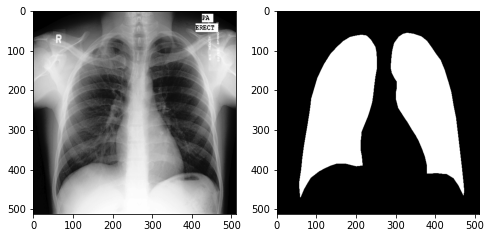

In [ ]:
i = 25
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
axs[0].imshow(X[i], cmap='gray')
axs[1].imshow(y[i], cmap='gray')

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split((X - 127.0) / 127.0, 
                                                  (y > 127).astype(np.float32), 
                                                  test_size = 0.15, 
                                                  random_state = 0)
X_testNorm = (X_test - 127.0) / 127.0

## Setup Model

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred) 

In [ ]:
def XNet(input_shape=(256,256,1), classes=1, kernel_size = 3, filter_depth = (16,32,64,128,0)):
    img_input = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(img_input)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation("relu")(batch1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act1)
    #100x100
    
    conv2 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(pool1)
    batch2 = BatchNormalization()(conv2)
    act2 = Activation("relu")(batch2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
    #50x50
    
    conv3 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool2)
    batch3 = BatchNormalization()(conv3)
    act3 = Activation("relu")(batch3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act3)
    #25x25
    
    #Flat
    conv4 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool3)
    batch4 = BatchNormalization()(conv4)
    act4 = Activation("relu")(batch4)
    #25x25
    
    conv5 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act4)
    batch5 = BatchNormalization()(conv5)
    act5 = Activation("relu")(batch5)
    #25x25
    
    #Up
    up6 = UpSampling2D(size=(2, 2))(act5)
    conv6 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up6)
    batch6 = BatchNormalization()(conv6)
    act6 = Activation("relu")(batch6)
    concat6 = Concatenate()([act3,act6])
    #50x50
    
    up7 = UpSampling2D(size=(2, 2))(concat6)
    conv7 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up7)
    batch7 = BatchNormalization()(conv7)
    act7 = Activation("relu")(batch7)
    concat7 = Concatenate()([act2,act7])
    #100x100
    
    #Down
    conv8 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(concat7)
    batch8 = BatchNormalization()(conv8)
    act8 = Activation("relu")(batch8)
    pool8 = MaxPooling2D(pool_size=(2, 2))(act8)
    #50x50
    
    conv9 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool8)
    batch9 = BatchNormalization()(conv9)
    act9 = Activation("relu")(batch9)
    pool9 = MaxPooling2D(pool_size=(2, 2))(act9)
    
    #25x25
    
    #Flat
    conv10 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool9)
    batch10 = BatchNormalization()(conv10)
    act10 = Activation("relu")(batch10)
    #25x25
    
    conv11 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act10)
    batch11 = BatchNormalization()(conv11)
    act11 = Activation("relu")(batch11)
    #25x25
    
    #Encoder
    up12 = UpSampling2D(size=(2, 2))(act11)
    conv12 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up12)
    batch12 = BatchNormalization()(conv12)
    act12 = Activation("relu")(batch12)
    concat12 = Concatenate()([act9,act12])
    #50x50
    
    up13 = UpSampling2D(size=(2, 2))(concat12)
    conv13 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up13)
    batch13 = BatchNormalization()(conv13)
    act13 =  Activation("relu")(batch13)
    concat13 = Concatenate()([act8,act13])
    #100x100
    
    up14 = UpSampling2D(size=(2, 2))(concat13)
    conv14 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(up14)
    batch14 = BatchNormalization()(conv14)
    act14 = Activation("relu")(batch14)
    concat14 = Concatenate()([act1,act14])
    #200x200
    
    conv15 = Conv2D(1, (1, 1), activation='sigmoid')(concat14)

    return Model(inputs=[img_input], outputs=[conv15])

In [ ]:
model = XNet(input_shape=(dim, dim, 1))

In [ ]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=35) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

In [ ]:
model.compile(optimizer = Adam(lr = 1e-4), 
              loss = loss, 
              metrics = metrics)

## Training

In [ ]:
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=16, epochs=80,
                callbacks=callbacks_list)

Epoch 1/80
38/38 [==============================] - 28s 444ms/step - loss: -0.4854 - dice_coef: 0.4854 - jaccard_coef: 0.3270 - binary_accuracy: 0.7773 - precision: 0.5454 - recall: 0.7047 - val_loss: -0.3121 - val_dice_coef: 0.3135 - val_jaccard_coef: 0.1859 - val_binary_accuracy: 0.7530 - val_precision: 4.2057e-04 - val_recall: 1.4622e-06

Epoch 00001: val_loss improved from inf to -0.31207, saving model to cxr_reg_weights.best.hdf5
Epoch 2/80
38/38 [==============================] - 14s 367ms/step - loss: -0.6845 - dice_coef: 0.6845 - jaccard_coef: 0.5207 - binary_accuracy: 0.9356 - precision: 0.8307 - recall: 0.9354 - val_loss: -0.2894 - val_dice_coef: 0.2906 - val_jaccard_coef: 0.1700 - val_binary_accuracy: 0.7538 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_loss did not improve from -0.31207
Epoch 3/80
38/38 [==============================] - 14s 369ms/step - loss: -0.7264 - dice_coef: 0.7264 - jaccard_coef: 0.5705 - binary_accuracy: 0.9570 - precision: 

## Training History

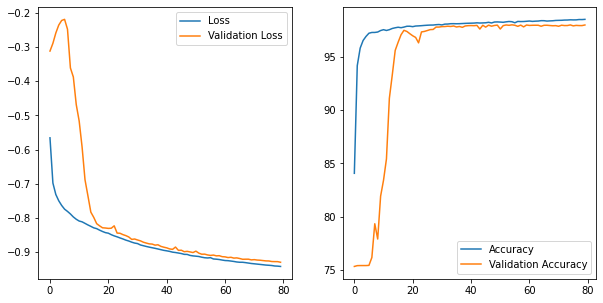

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

## Test Model on New Data

In [ ]:
preds = model.predict(X_testNorm)

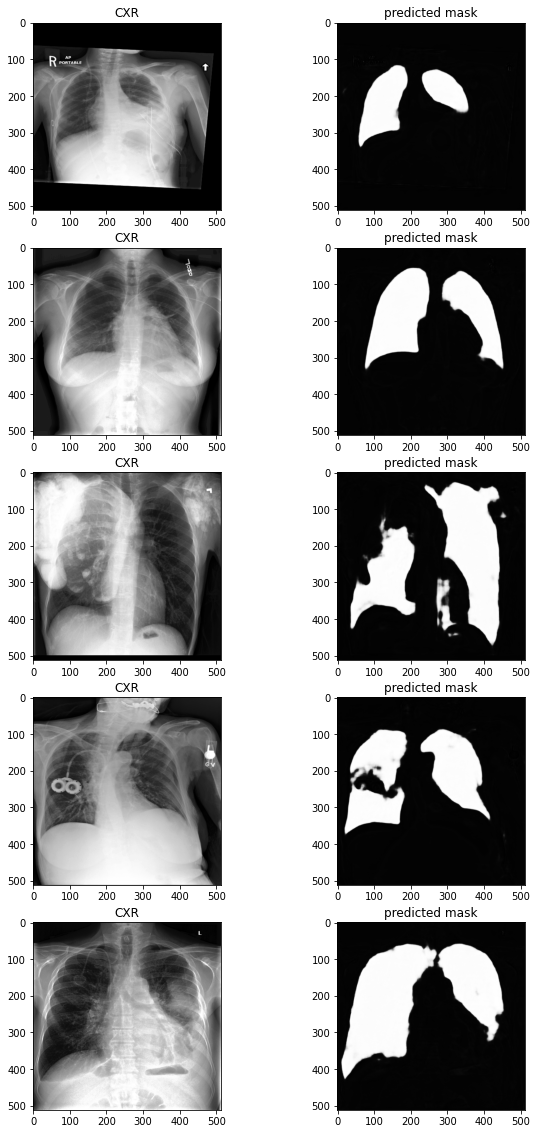

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i], cmap='gray')
            axs[i, j].set_title('CXR')
        else:
            axs[i, j].imshow(preds[i], cmap='gray')
            axs[i, j].set_title('predicted mask')